In [4]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.6 MB/s eta 0:00:00


## Importing saved articles

In [8]:
# Read the list of Women EE names
df = pd.read_csv('WE_name_country.csv', names = ['name', 'country'])
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('WE_articles/' + filename)

    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))
        for article in text[1:]:
            all_articles.append(article[1])

    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

# Number of articles in initial list by country
articles_df.groupby('country').count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of articles: 2046
After de-duplication: 1594


,articles
country,
Austria,82
Belgium,144
France,475
Germany,508
Lienchshtein,14
Luxembourg,23
Monaco,11
Netherlands,206
Switzerland,131


In [6]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [7]:
%cd '/content/drive/My Drive/wiki_nlp/Western Europe Wiki'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/content/drive/.shortcut-targets-by-id/15s6PM-2Nd6EW69jV8dfs1SLHd7lUYTnj/wiki_nlp/Western Europe Wiki


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing and tokenisation

In [11]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english')
ee_stop_df = pd.read_csv('WE_stop_list.csv')

# Combine lists
ee_stop_words = stop_words + list(ee_stop_df.token)

wnl = WordNetLemmatizer()

# Check for latin alphabet
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df['articles']:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)

    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)

    doc_out = []
    for word in tokens:
        if word not in ee_stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)

    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokens groups: 1594 

-No-   --Tokens--
  1       106
  2       112
  3       174
  4       112
  5        94
  6        51
  7       617
  8       149
  9       179
 10       205
 11        37
 12       184
 13         9
 14       123
 15       266


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dictionary and corpus

In [12]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary length: 1032
Top 20 tokens by frequency

1. party - 3286
2. election - 2787
3. elected - 1715
4. state - 1676
5. committee - 1673
6. council - 1512
7. minister - 1491
8. group - 1479
9. national - 1466
10. federal - 1409
11. became - 1382
12. board - 1365
13. served - 1340
14. parliament - 1302
15. parliamentary - 1292
16. university - 1240
17. president - 1221
18. first - 1167
19. government - 1137
20. social - 1096

Corpus created. 
Corpus length: 1594


In [21]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/WE_NG_frequency_top_250.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


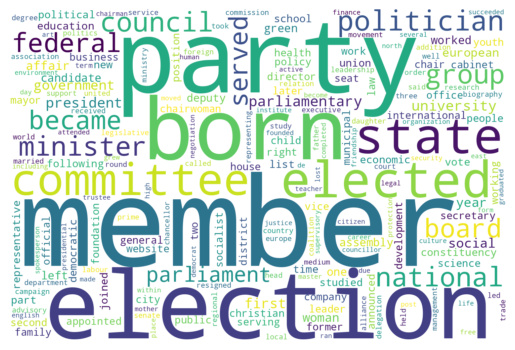

In [22]:
# WordCloud based on all tokens
# combine all tokens into one string
text = ""
for token_list in all_tokens:
    for token in token_list:
        text = text + " " + token

# Create and generate a word cloud image:
# https://www.datacamp.com/tutorial/wordcloud-python - parameters
wordcloud = WordCloud(background_color = "white", collocations = False,
                      width = 1500, height = 1000, stopwords = None).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bigrams

In [23]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique bigrams in the articles: 170375


,bigram,count
0,"(born, politician)",739
1,"(member, board)",607
2,"(national, assembly)",526
3,"(federal, election)",478
4,"(parliamentary, group)",471
5,"(democratic, party)",390
6,"(house, representative)",362
7,"(became, member)",319
8,"(member, national)",312
9,"(legislative, election)",306


In [24]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/WE_NG_bigrams_100.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


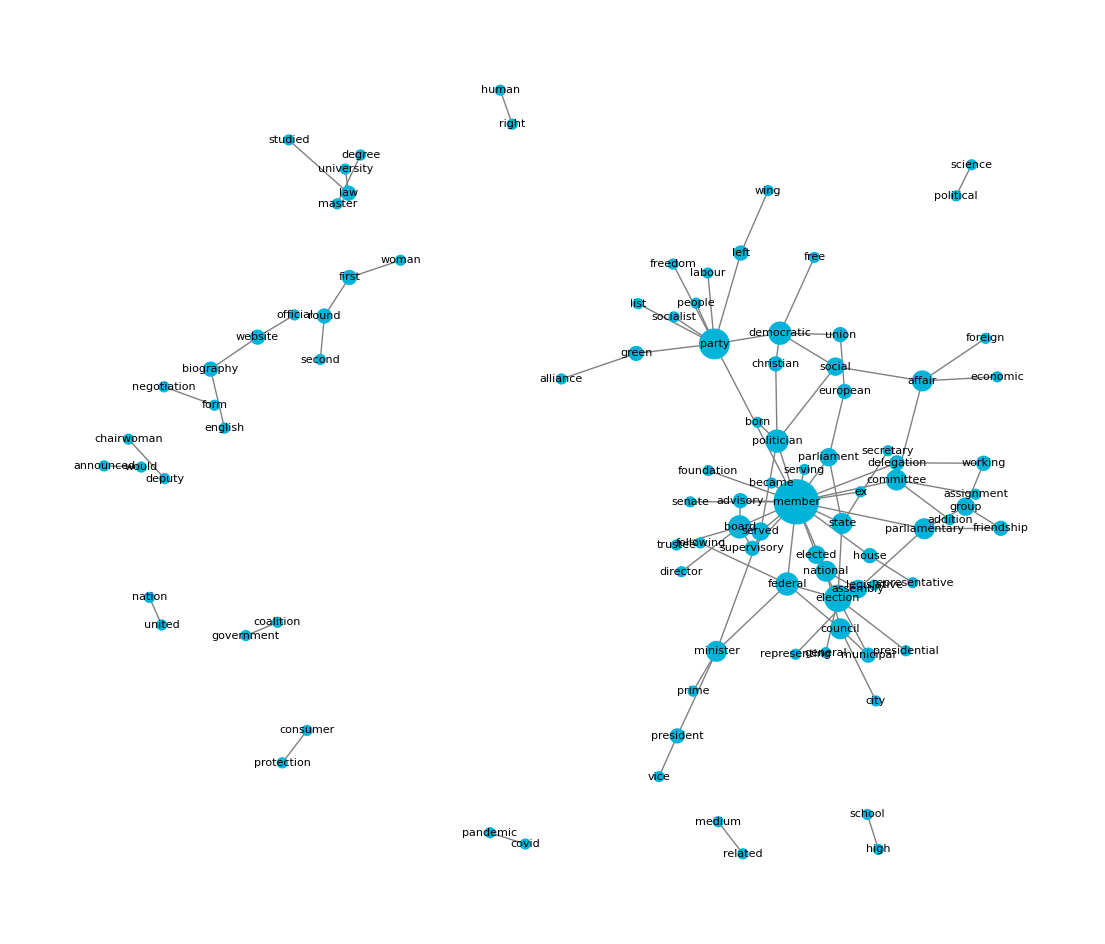

In [25]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True,
        nodelist=d.keys(),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [26]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


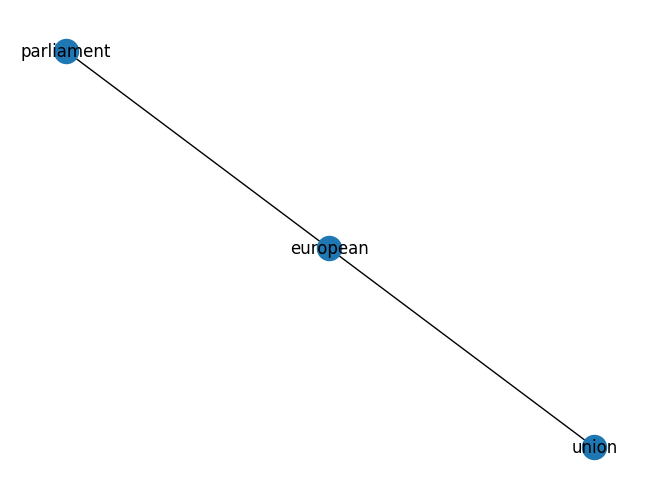

In [27]:
# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['european'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True)
plt.show()

In [28]:
# Or as a list
list(G.adj['politician'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['born', 'member', 'served', 'social', 'christian']

## Trigrams

In [29]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_)

print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total number of documents with trigrams: 1137
Number of unique trigrams: 139

Top 20 trigrams by frequency

1. social_democratic_party - 200
2. addition_committee_assignment - 154
3. member_national_assembly - 152
4. member_board_trustee - 136
5. member_house_representative - 130
6. parliamentary_friendship_group - 124
7. christian_democratic_union - 96
8. member_supervisory_board - 89
9. government_prime_minister - 60
10. free_democratic_party - 58
11. university_applied_science - 55
12. member_advisory_board - 54
13. parliamentary_group_rapporteur - 53
14. party_delegation_working - 52
15. elected_house_representative - 46
16. committee_foreign_affair - 46
17. committee_legal_affair - 44
18. studied_political_science - 43
19. member_chamber_representative - 40
20. negotiation_form_coalition - 40


In [30]:
# Writing top 50 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:50])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/WE_NG_trigrams_50.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


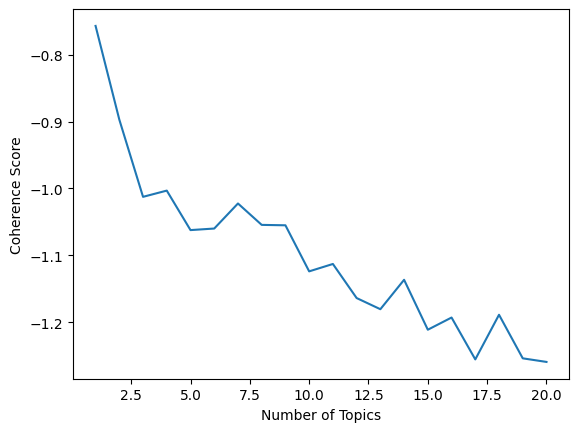

In [46]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                             iterations = 300, num_topics = i,
                             workers = 4, passes = 30,
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


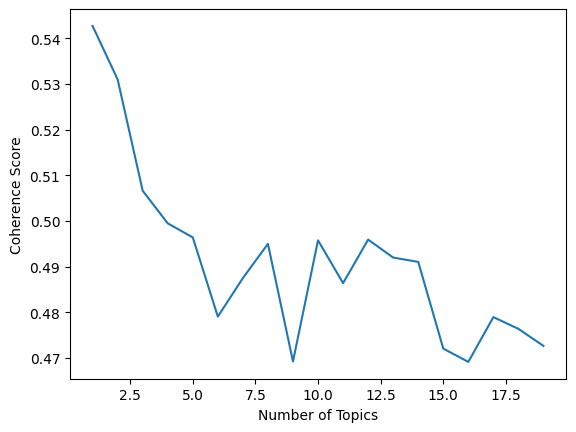

In [34]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary,
                             iterations=300, num_topics=i,
                             workers = 4, passes=30, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus,
                        dictionary=dictionary,
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA model

In [13]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                         iterations = 100, num_topics = 15,
                         workers = 4, passes = 10,
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
cm_score = cm.get_coherence()

print('LDA model coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA model coherence score: -1.0419825662898112

Topic: 0 
Words: 0.055*"green" + 0.043*"state" + 0.033*"party" + 0.028*"election" + 0.022*"parliament" + 0.020*"federal" + 0.019*"committee" + 0.016*"alliance" + 0.016*"university" + 0.014*"parliamentary"

Topic: 1 
Words: 0.039*"election" + 0.037*"national" + 0.036*"elected" + 0.025*"assembly" + 0.020*"party" + 0.020*"constituency" + 0.019*"council" + 0.017*"mayor" + 0.016*"first" + 0.015*"candidate"

Topic: 2 
Words: 0.052*"committee" + 0.036*"parliamentary" + 0.029*"group" + 0.025*"federal" + 0.025*"election" + 0.018*"affair" + 0.016*"state" + 0.016*"party" + 0.016*"served" + 0.016*"board"

Topic: 3 
Words: 0.028*"party" + 0.027*"council" + 0.019*"elected" + 0.018*"federal" + 0.017*"election" + 0.016*"social" + 0.014*"national" + 0.013*"school" + 0.012*"woman" + 0.011*"university"

Topic: 4 
Words: 0.036*"federal" + 0.034*"party" + 0.032*"council" + 0.027*"board" + 0.019*"president" + 0.019*"election" + 0.017*"served" + 0.017*"elected"

## LDA Visualisation

In [14]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.038785  0.001966       1        1  14.859587
11    -0.051739  0.068384       2        1  10.244574
1      0.076071  0.101718       3        1   9.982140
12    -0.173228 -0.035236       4        1   9.477108
2      0.166137 -0.105101       5        1   8.421275
3      0.023669  0.024791       6        1   7.041207
4      0.072911 -0.028396       7        1   5.971310
6     -0.060793 -0.027390       8        1   5.872319
0      0.115032  0.043071       9        1   5.291726
8     -0.028704 -0.062709      10        1   4.659367
5     -0.076899  0.128333      11        1   4.285922
9     -0.120743 -0.021826      12        1   3.717984
7      0.010059  0.104663      13        1   3.606505
13     0.196304 -0.047564      14        1   3.492580
14    -0.109294 -0.144705      15        1   3.076398, topic_info=           Term         Freq        Total Category  logprob  loglift
29    committee  1702.000000  1702.000000  Default  30.0000  30.0000
371       green   790.000000   790.000000  Default  29.0000  29.0000
57        party  3235.000000  3235.000000  Default  28.0000  28.0000
634    assembly   781.000000   781.000000  Default  27.0000  27.0000
189       board  1361.000000  1361.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
428      leader    29.202176   530.768895  Topic15  -5.1497   0.5813
119      served    33.527167  1333.302303  Topic15  -5.0116  -0.2016
98   government    30.979793  1122.888864  Topic15  -5.0906  -0.1089
97        first    28.367524  1148.761343  Topic15  -5.1787  -0.2198
66        study    26.273168   373.850222  Topic15  -5.2554   0.8261

[892 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1029      1  0.045644  abitur
1029      2  0.030430  abitur
1029      5  0.258651  abitur
1029      6  0.167363  abitur
1029      7  0.045644  abitur
...     ...       ...     ...
132      11  0.065143   youth
132      12  0.005011   youth
132      13  0.005011   youth
132      14  0.002505   youth
132      15  0.005011   youth

[5702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 2, 13, 3, 4, 5, 7, 1, 9, 6, 10, 8, 14, 15])

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

## Bigram visualisation - Node colouring by topic

In [ ]:
# Creating dataframe with node names and topics identified by LDA for colour coding nodes
# ISSUE: many words do not have topics - bigrams in dictionary?
#->> These tokens are not in the dictionary (as bigrams are build based on full token list)
nodes_df = pd.DataFrame(list(G.nodes), columns=['nodes'])

# After LDA model is built
topic_list = []
for word in nodes_df.nodes:
    try:
        t_probability = lda_model.get_term_topics(word)
        # Find for the topic with the highest probability
        if len(t_probability) > 1:
            highest_topic = ''
            highest_probability = 0
            for topic, prob in t_probability:
                if prob > highest_probability:
                    highest_topic = topic
                    highest_probability = prob
            topic_list.append(highest_topic)
        else:
            topic_list.append(t_probability[0][0])
    except (RuntimeError, TypeError, NameError, IndexError):
        topic_list.append('')
        pass
nodes_df['topic'] = topic_list
# Convert topic column to catgorical
nodes_df['topic'] = pd.Categorical(nodes_df['topic'])

nodes_df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nodes,topic
0,born,
1,politician,
2,member,
3,board,3
4,national,1
5,assembly,1
6,federal,4
7,election,1
8,parliamentary,4
9,group,4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


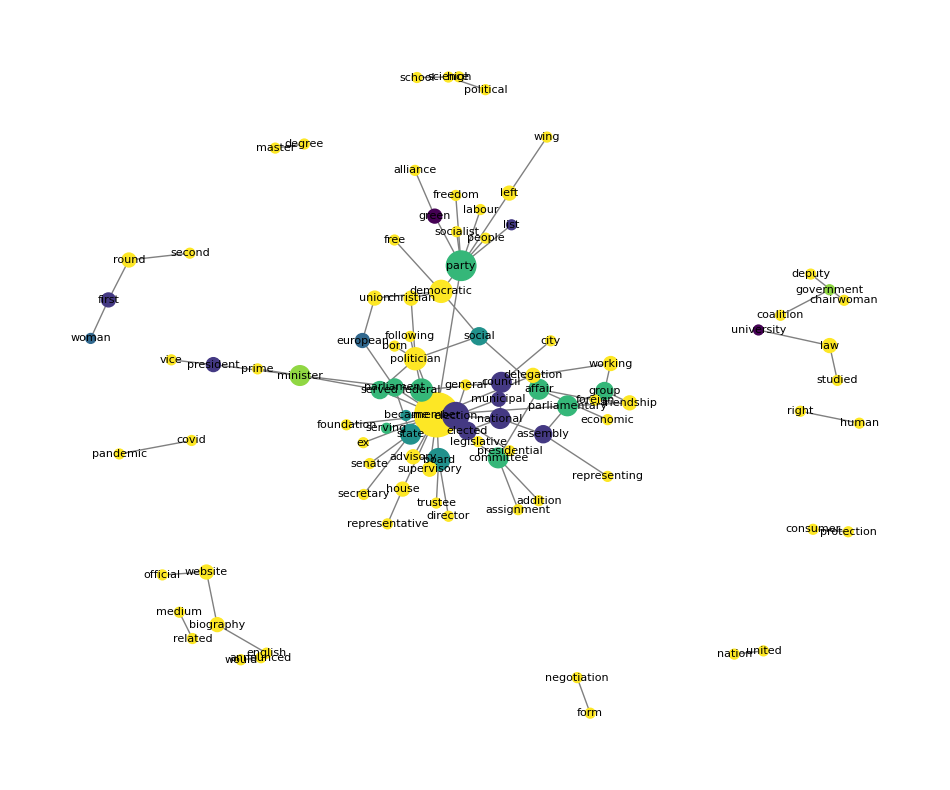

In [ ]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color = nodes_df['topic'].cat.codes,
        with_labels = True,
        nodelist=d.keys(),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [ ]:
# 0 (topic 1) - dark purple (e.g. party)
# NA - yellow (common across all documents)

print('Number of nodes per topic:')
print(nodes_df['topic'].value_counts().sort_index())

Number of nodes per topic:
topic
0     2
1     9
2     2
3     4
4     9
5     2
     70
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Testing model

In [62]:
# probability of a word belonging to a topic
test_words = ['business']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: business  - belongs to:
Topic: 12 
Probability: 0.017135994508862495

Topic: 14 
Probability: 0.012090022675693035



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
query = 'leadership self-efficacy or LSE an individual confidence  his  her ability to carry out necessary leadership behaviors, such  delegating, making decisions, motivating others'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]
# This shows how the query relates to the topics
vec_lda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.03370027),
 (1, 0.033524316),
 (2, 0.64952767),
 (3, 0.0336469),
 (4, 0.21588522),
 (5, 0.03371561)]